# Main Script Bank Telemarketing Dataset

First required packages and the data is loaded. Note that both the training- and validation dataset as well as the test dataset are taken from the bank-full.csv dataset. A random sampel of 6'000 nodes is taken for both subsets. 

If the dataset would be considered for the results chapter, the dataset would have first been randomly split into two datasets and then subsampled separately. The results do however not differ in any significant way. When sampling from the same dataset, technically identical observations could be present in both training and test dataset. Given the large size of the original datset with over 45'000 observations, this is unlikely to cause a problem or significantly bias the results.

In [35]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
df_train_valid = df.sample(n=6000,replace=False)
df_feature_train = df_train_valid.copy(deep=True)
# df_train_valid = pd.read_csv('bank.csv',sep=';')
df_train_valid.reset_index(inplace=True,drop=True)
df_test = df.sample(n=6000,replace=False)
df_test.reset_index(inplace=True,drop=True)

Below the unbalanced label distribution for both datasets is shown

In [3]:
df_train_valid.y.value_counts(normalize=True)

no     0.883
yes    0.117
Name: y, dtype: float64

In [4]:
df_test.y.value_counts(normalize=True)

no     0.879833
yes    0.120167
Name: y, dtype: float64

In [5]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,50,management,divorced,secondary,no,458,no,no,cellular,3,feb,184,3,-1,0,unknown,no
1,34,blue-collar,married,secondary,no,103,yes,yes,unknown,8,may,956,2,-1,0,unknown,no
2,47,housemaid,single,secondary,no,17023,no,no,cellular,26,may,379,2,97,4,other,no
3,39,entrepreneur,married,secondary,no,689,no,no,cellular,30,jul,240,3,-1,0,unknown,no
4,56,retired,married,primary,no,-1,no,no,cellular,27,aug,89,23,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,31,admin.,married,tertiary,no,323,no,no,cellular,11,aug,120,3,-1,0,unknown,no
5996,56,unemployed,married,primary,no,107,yes,no,cellular,19,nov,149,1,-1,0,unknown,no
5997,50,management,married,secondary,no,309,no,no,telephone,5,jun,113,1,-1,0,unknown,no
5998,47,housemaid,married,primary,no,183,no,no,cellular,13,aug,144,1,-1,0,unknown,no


## The variables are recoded into a useful format

In [6]:
df_train_valid.age = df_train_valid.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_train_valid.job = df_train_valid.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_train_valid.marital = df_train_valid.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_train_valid.education = df_train_valid.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_train_valid.default = df_train_valid.default.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.balance = df_train_valid.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_train_valid.housing = df_train_valid.housing.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.loan = df_train_valid.loan.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.contact = df_train_valid.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

#df_train_valid.duration = df_train_valid.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_train_valid.pdays = df_train_valid.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_train_valid.poutcome = df_train_valid.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_train_valid.y = df_train_valid.y.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.drop(columns = ['day','month'],inplace=True)


In [7]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,3,1,2,1,0,3,0,0,1,184,3,1,0,2,0
1,1,1,1,1,0,2,1,1,2,956,2,1,0,2,0
2,2,1,0,1,0,4,0,0,1,379,2,0,4,2,0
3,2,1,1,1,0,3,0,0,1,240,3,1,0,2,0
4,3,2,1,0,0,0,0,0,1,89,23,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,1,1,2,0,2,0,0,1,120,3,1,0,2,0
5996,3,3,1,0,0,2,1,0,1,149,1,1,0,2,0
5997,3,1,1,1,0,2,0,0,0,113,1,1,0,2,0
5998,2,1,1,0,0,2,0,0,1,144,1,1,0,2,0


## The Correlation Matrix of the Dataset

In [8]:
corr = df_train_valid.corr()
corr

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.281697,0.383361,-0.088081,-0.013490,0.102475,-0.169163,-0.030216,-0.070722,-0.009139,0.003505,-0.033861,0.009401,-0.004279,0.006825
job,0.281697,1.000000,0.114574,-0.101156,0.011543,0.040195,-0.110142,-0.019143,-0.053193,0.026305,-0.023900,0.016505,-0.007235,0.018896,0.026975
marital,0.383361,0.114574,1.000000,-0.110983,0.002342,-0.032822,0.020419,0.026656,0.019317,-0.032671,0.007428,0.017658,-0.003465,0.015297,-0.044370
education,-0.088081,-0.101156,-0.110983,1.000000,-0.002455,0.062037,-0.104999,-0.047219,-0.054338,0.009148,-0.022553,-0.030547,0.002554,-0.006564,0.087488
default,-0.013490,0.011543,0.002342,-0.002455,1.000000,-0.172600,-0.021578,0.057315,0.029475,-0.024116,0.044795,0.025839,-0.022003,0.036326,-0.016172
balance,0.102475,0.040195,-0.032822,0.062037,-0.172600,1.000000,-0.082491,-0.129242,-0.064810,0.045282,-0.046616,-0.073515,0.043055,-0.051188,0.094540
housing,-0.169163,-0.110142,0.020419,-0.104999,-0.021578,-0.082491,1.000000,0.042995,0.205215,0.017756,-0.037836,0.077091,0.043305,-0.081479,-0.128283
loan,-0.030216,-0.019143,0.026656,-0.047219,0.057315,-0.129242,0.042995,1.000000,0.003801,-0.006761,0.006782,0.032155,0.006332,0.000738,-0.060698
contact,-0.070722,-0.053193,0.019317,-0.054338,0.029475,-0.064810,0.205215,0.003801,1.000000,0.002639,-0.027785,0.132223,-0.175210,0.200263,-0.137313
duration,-0.009139,0.026305,-0.032671,0.009148,-0.024116,0.045282,0.017756,-0.006761,0.002639,1.000000,-0.098137,-0.023395,-0.007756,-0.004927,0.402841


## Duration Attribute

It is investigated, whether the attribute duration should be added as an attribute. This variable has the largest correlation with the label, which why it is considered as a partial substitute for the label. Using duration as an additional attribute unfortunately did not show to improve the classification accuracy. For that reason, the graph shown in the master's thesis including the results correspond to the graph which does not make use of the attribute duration. For simulation purposes, the duration attribute can easily be adding its link-affinity matrix to the link-affinity dictionary used in the MAG model.

In [9]:
df_train_valid.duration.describe()

count    6000.000000
mean      257.790500
std       260.963163
min         0.000000
25%       105.000000
50%       181.000000
75%       313.000000
max      3881.000000
Name: duration, dtype: float64

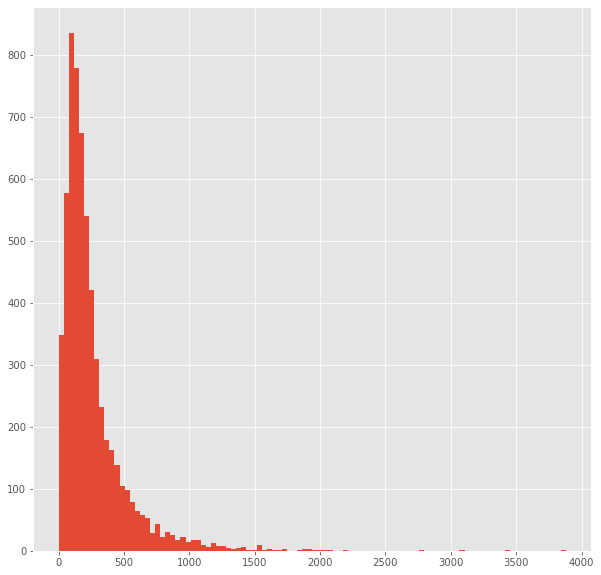

In [10]:
plt.figure(figsize=(10,10))
plt.hist(df_train_valid.duration,bins=100)
#plt.hist(df_train_valid.y,bins=100)
plt.show()

In [11]:
value_comparison = (df_train_valid.duration > 400)

In [12]:
value_comparison

0       False
1        True
2       False
3       False
4       False
        ...  
5995    False
5996    False
5997    False
5998    False
5999    False
Name: duration, Length: 6000, dtype: bool

In [13]:
df_train_valid.y[value_comparison].sum()

385

(array([657.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 385.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

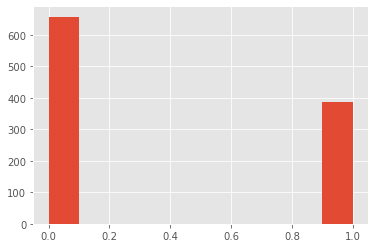

In [14]:
plt.hist(df_train_valid.y[value_comparison==True])

## Attribute Selection

In [15]:
# below, the label y can be included to generate the biased graph
# add y for biased graph
genvars = df_train_valid[['age','job','marital','education','balance','housing']]
#genvars = df_train_valid[['age','job','marital','education','balance','housing','duration']]
genvars.describe()

,age,job,marital,education,balance,housing
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.899167,1.105833,0.834000,1.217667,2.413333,0.556833
std,0.819417,0.455705,0.601529,0.742100,1.260722,0.496801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000
max,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000


## Link-affinity matrices

To create the biased graph, add the link-affinity matrix of the label to the affinity matrix dictionary. Further, the label must be added to the matrix containing the attributes

In [16]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])


# duration
dur_alpha0 = 0.70
dur_alpha1 = 0.95
dur_beta1 = 0.25

aff_dur = np.array([[dur_alpha0,dur_beta1],
                  [dur_beta1,dur_alpha1]])

# outcome

y_alpha1 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha1,y_beta1],
                  [y_beta1,y_alpha1]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

## MAG Model

In [17]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [18]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [19]:
A = A + A.T
np.sum(A) / 2

2247438.0

## Create and Plot the Graph

In [20]:
G = nx.from_numpy_matrix(A)

In [21]:
nx.is_connected(G)

True

In [22]:
# nx.draw(G,node_size=20)

In [23]:
features = pd.Series(df_train_valid.y)

In [24]:
df_train_valid.drop(columns=['y'],inplace=True)

In [25]:
not_invest = features.index[features == 0].tolist()
invest = features.index[features == 1].tolist()

In [26]:
pos = nx.spring_layout(G)

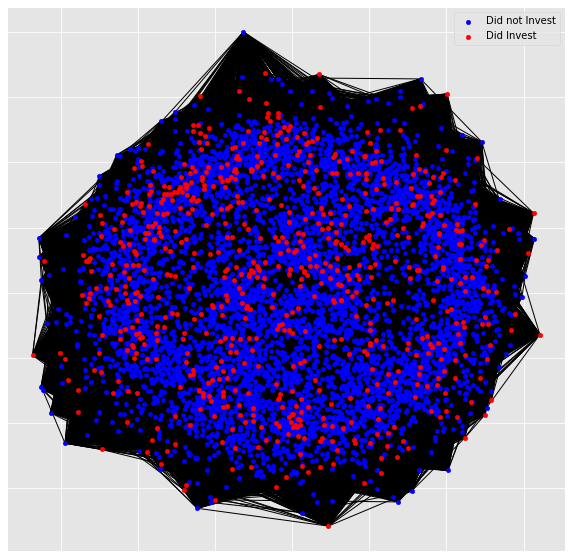

In [27]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=not_invest,node_size=20,node_color='b',label='Did not Invest')
nx.draw_networkx_nodes(G,pos,nodelist=invest,node_size=20,node_color='r',label='Did Invest')
nx.draw_networkx_edges(G,pos)

plt.legend()
plt.show()

## Prepare the Data for GNNs

In [28]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [29]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,3,1,2,1,0,3,0,0,1,184,3,1,0,2
1,1,1,1,1,0,2,1,1,2,956,2,1,0,2
2,2,1,0,1,0,4,0,0,1,379,2,0,4,2
3,2,1,1,1,0,3,0,0,1,240,3,1,0,2
4,3,2,1,0,0,0,0,0,1,89,23,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,1,1,2,0,2,0,0,1,120,3,1,0,2
5996,3,3,1,0,0,2,1,0,1,149,1,1,0,2
5997,3,1,1,1,0,2,0,0,0,113,1,1,0,2
5998,2,1,1,0,0,2,0,0,1,144,1,1,0,2


In [30]:
df_feature_train.reset_index(inplace=True,drop=True)
df_train_valid.age = df_feature_train.age
df_train_valid.balance = df_feature_train.balance
#df_train_valid.drop(columns = ['day','month'],inplace=True)
df_train_valid.duration = df_feature_train.duration


In [31]:
#df_train_valid.drop(columns = ['pdays'],inplace=True)
#df_train_valid.previous = df_feature_train.previous
df_train_valid.describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,40.998000,1.105833,0.834000,1.217667,0.017167,1389.32850,0.556833,0.161000,1.215667,257.790500,2.733167,0.946167,0.594167,1.746333
std,10.799094,0.455705,0.601529,0.742100,0.129903,3018.03489,0.496801,0.367562,0.556662,260.963163,2.993124,0.225707,1.936171,0.640355
min,18.000000,0.000000,0.000000,0.000000,0.000000,-1941.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,32.000000,1.000000,0.000000,1.000000,0.000000,68.00000,0.000000,0.000000,1.000000,105.000000,1.000000,1.000000,0.000000,2.000000
50%,39.000000,1.000000,1.000000,1.000000,0.000000,464.50000,1.000000,0.000000,1.000000,181.000000,2.000000,1.000000,0.000000,2.000000
75%,49.000000,1.000000,1.000000,2.000000,0.000000,1445.25000,1.000000,0.000000,2.000000,313.000000,3.000000,1.000000,0.000000,2.000000
max,95.000000,3.000000,2.000000,3.000000,1.000000,81204.00000,1.000000,1.000000,2.000000,3881.000000,38.000000,1.000000,30.000000,2.000000


In [32]:
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Prepare the dgl data and assign features and label

In [36]:
G_dgl = dgl.from_networkx(G)
feat = df_train_valid.copy(deep=True)
#feat = pd.get_dummies(feat)
scale = StandardScaler()
feat = pd.DataFrame(scale.fit_transform(feat))

G_dgl.ndata['feat'] =  torch.tensor(feat.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [37]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [38]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [39]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

## Define Dataloaders for minibatch training

In [40]:

batch_size = 50
#sampler = dgl.dataloading.MultiLayerNeighborSampler([4, 4, 4])
sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
#sampler = dgl.dataloading.MultiLayerNeighborSampler([None])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [41]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [42]:
print(len(train_nids))
print(len(valid_nids))
print(len(G.nodes()))

4797
1203
6000


## Define GraphSage Model

In [43]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

## Train GraphSage and get Results

In [44]:
model = SAGE(n_features, 124, n_labels, 2) #n_layers
opt = torch.optim.Adam(model.parameters())

In [45]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)

Epoch: 0, Training Accuracy: 0.872, Training Loss: 0.370
Epoch: 0, Validation Accuracy: 0.883, Validation Loss: 0.334, Time: 3.0245
Epoch: 1, Training Accuracy: 0.883, Training Loss: 0.316
Epoch: 1, Validation Accuracy: 0.883, Validation Loss: 0.300, Time: 2.3843
Epoch: 2, Training Accuracy: 0.885, Training Loss: 0.283
Epoch: 2, Validation Accuracy: 0.886, Validation Loss: 0.278, Time: 2.1393
Epoch: 3, Training Accuracy: 0.888, Training Loss: 0.264
Epoch: 3, Validation Accuracy: 0.886, Validation Loss: 0.268, Time: 1.9934
Epoch: 4, Training Accuracy: 0.890, Training Loss: 0.258
Epoch: 4, Validation Accuracy: 0.881, Validation Loss: 0.265, Time: 1.8943
Epoch: 5, Training Accuracy: 0.893, Training Loss: 0.252
Epoch: 5, Validation Accuracy: 0.879, Validation Loss: 0.266, Time: 1.8224
Epoch: 6, Training Accuracy: 0.891, Training Loss: 0.247
Epoch: 6, Validation Accuracy: 0.877, Validation Loss: 0.269, Time: 1.7889
Epoch: 7, Training Accuracy: 0.894, Training Loss: 0.247
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.912, Training Loss: 0.211
Epoch: 62, Validation Accuracy: 0.886, Validation Loss: 0.254, Time: 1.6643
Epoch: 63, Training Accuracy: 0.906, Training Loss: 0.210
Epoch: 63, Validation Accuracy: 0.886, Validation Loss: 0.258, Time: 1.6654
Epoch: 64, Training Accuracy: 0.913, Training Loss: 0.211
Epoch: 64, Validation Accuracy: 0.885, Validation Loss: 0.257, Time: 1.6643
Epoch: 65, Training Accuracy: 0.911, Training Loss: 0.211
Epoch: 65, Validation Accuracy: 0.888, Validation Loss: 0.260, Time: 1.6625
Epoch: 66, Training Accuracy: 0.913, Training Loss: 0.209
Epoch: 66, Validation Accuracy: 0.888, Validation Loss: 0.254, Time: 1.6591
Epoch: 67, Training Accuracy: 0.911, Training Loss: 0.212
Epoch: 67, Validation Accuracy: 0.887, Validation Loss: 0.262, Time: 1.6541
Epoch: 68, Training Accuracy: 0.909, Training Loss: 0.211
Epoch: 68, Validation Accuracy: 0.887, Validation Loss: 0.263, Time: 1.6489
Epoch: 69, Training Accuracy: 0.910, Training Loss: 0.211
Epoc

Epoch: 123, Training Accuracy: 0.927, Training Loss: 0.185
Epoch: 123, Validation Accuracy: 0.882, Validation Loss: 0.273, Time: 1.6171
Epoch: 124, Training Accuracy: 0.922, Training Loss: 0.189
Epoch: 124, Validation Accuracy: 0.877, Validation Loss: 0.276, Time: 1.6148
Epoch: 125, Training Accuracy: 0.927, Training Loss: 0.180
Epoch: 125, Validation Accuracy: 0.874, Validation Loss: 0.276, Time: 1.6137
Epoch: 126, Training Accuracy: 0.924, Training Loss: 0.189
Epoch: 126, Validation Accuracy: 0.879, Validation Loss: 0.278, Time: 1.6127
Epoch: 127, Training Accuracy: 0.925, Training Loss: 0.184
Epoch: 127, Validation Accuracy: 0.883, Validation Loss: 0.276, Time: 1.6099
Epoch: 128, Training Accuracy: 0.926, Training Loss: 0.180
Epoch: 128, Validation Accuracy: 0.884, Validation Loss: 0.276, Time: 1.6170
Epoch: 129, Training Accuracy: 0.928, Training Loss: 0.184
Epoch: 129, Validation Accuracy: 0.878, Validation Loss: 0.279, Time: 1.6275
Epoch: 130, Training Accuracy: 0.927, Training L

Epoch: 184, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 184, Validation Accuracy: 0.875, Validation Loss: 0.300, Time: 1.8236
Epoch: 185, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 185, Validation Accuracy: 0.882, Validation Loss: 0.296, Time: 1.8311
Epoch: 186, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 186, Validation Accuracy: 0.877, Validation Loss: 0.299, Time: 1.8309
Epoch: 187, Training Accuracy: 0.935, Training Loss: 0.162
Epoch: 187, Validation Accuracy: 0.876, Validation Loss: 0.296, Time: 1.8300
Epoch: 188, Training Accuracy: 0.935, Training Loss: 0.161
Epoch: 188, Validation Accuracy: 0.876, Validation Loss: 0.296, Time: 1.8343
Epoch: 189, Training Accuracy: 0.938, Training Loss: 0.162
Epoch: 189, Validation Accuracy: 0.873, Validation Loss: 0.301, Time: 1.8520
Epoch: 190, Training Accuracy: 0.935, Training Loss: 0.163
Epoch: 190, Validation Accuracy: 0.877, Validation Loss: 0.297, Time: 1.8587
Epoch: 191, Training Accuracy: 0.936, Training L

Epoch: 245, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 245, Validation Accuracy: 0.874, Validation Loss: 0.322, Time: 1.9970
Epoch: 246, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 246, Validation Accuracy: 0.868, Validation Loss: 0.324, Time: 1.9998
Epoch: 247, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 247, Validation Accuracy: 0.874, Validation Loss: 0.319, Time: 2.0006
Epoch: 248, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 248, Validation Accuracy: 0.860, Validation Loss: 0.326, Time: 2.0042
Epoch: 249, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 249, Validation Accuracy: 0.877, Validation Loss: 0.329, Time: 2.0147
Epoch: 250, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 250, Validation Accuracy: 0.878, Validation Loss: 0.323, Time: 2.0139
Epoch: 251, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 251, Validation Accuracy: 0.864, Validation Loss: 0.327, Time: 2.0178
Epoch: 252, Training Accuracy: 0.942, Training L

Epoch: 306, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 306, Validation Accuracy: 0.870, Validation Loss: 0.331, Time: 2.0322
Epoch: 307, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 307, Validation Accuracy: 0.865, Validation Loss: 0.331, Time: 2.0314
Epoch: 308, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 308, Validation Accuracy: 0.868, Validation Loss: 0.334, Time: 2.0304
Epoch: 309, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 309, Validation Accuracy: 0.866, Validation Loss: 0.338, Time: 2.0298
Epoch: 310, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 310, Validation Accuracy: 0.865, Validation Loss: 0.337, Time: 2.0302
Epoch: 311, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 311, Validation Accuracy: 0.863, Validation Loss: 0.339, Time: 2.0307
Epoch: 312, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 312, Validation Accuracy: 0.873, Validation Loss: 0.333, Time: 2.0349
Epoch: 313, Training Accuracy: 0.945, Training L

Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 367, Validation Accuracy: 0.866, Validation Loss: 0.349, Time: 2.0006
Epoch: 368, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 368, Validation Accuracy: 0.863, Validation Loss: 0.345, Time: 2.0007
Epoch: 369, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 369, Validation Accuracy: 0.870, Validation Loss: 0.340, Time: 1.9992
Epoch: 370, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 370, Validation Accuracy: 0.866, Validation Loss: 0.345, Time: 1.9978
Epoch: 371, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 371, Validation Accuracy: 0.870, Validation Loss: 0.349, Time: 1.9969
Epoch: 372, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 372, Validation Accuracy: 0.862, Validation Loss: 0.348, Time: 1.9964
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 373, Validation Accuracy: 0.863, Validation Loss: 0.346, Time: 1.9958
Epoch: 374, Training Accuracy: 0.948, Training L

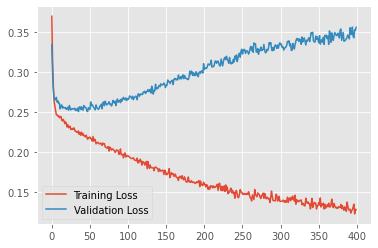

In [46]:
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

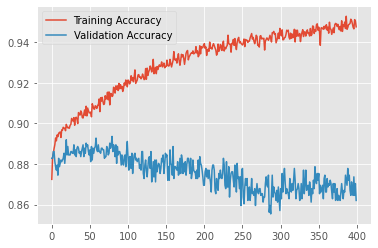

In [47]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [48]:
len(predictions)

1203

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy validation set {}'.format(accuracy_score(valid_labels,predictions)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(valid_labels, predictions))

Classification Accuracy validation set 0.8620116375727348
-------------------------------------------------------------
Confusion Matrix validation set:
[[985  77]
 [ 89  52]]


In [50]:
best_accuracy

0

In [51]:
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=14, out_features=14, bias=True)
      (fc_self): Linear(in_features=14, out_features=124, bias=False)
      (fc_neigh): Linear(in_features=14, out_features=124, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=124, out_features=124, bias=True)
      (fc_self): Linear(in_features=124, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=124, out_features=2, bias=False)
    )
  )
)>

In [52]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

roc_auc_score(valid_labels,predictions)
#plot_roc_curve(logits, X_test, y_test) 

0.6481448090716032

## Standard Machine Learning Results

### ANN

In [53]:
from sklearn.model_selection import train_test_split
f =  pd.get_dummies(features)
#x = df.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(feat,f, test_size = 0.2, shuffle=True)

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model_ann = Sequential()

model_ann.add(Dense(15, activation='relu'))
#model_ann.add(Dense(8, activation='relu'))
model_ann.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_ann.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=50, batch_size=10)

Epoch 1/50
480/480 [==============================] - 1s 2ms/step - loss: 0.4641 - accuracy: 0.8750 - val_loss: 0.2828 - val_accuracy: 0.8883
Epoch 2/50
480/480 [==============================] - 1s 1ms/step - loss: 0.2821 - accuracy: 0.8826 - val_loss: 0.2571 - val_accuracy: 0.8900
Epoch 3/50
480/480 [==============================] - 1s 2ms/step - loss: 0.2496 - accuracy: 0.8869 - val_loss: 0.2515 - val_accuracy: 0.8925
Epoch 4/50
480/480 [==============================] - 1s 2ms/step - loss: 0.2417 - accuracy: 0.8924 - val_loss: 0.2482 - val_accuracy: 0.8950
Epoch 5/50
480/480 [==============================] - 1s 2ms/step - loss: 0.2473 - accuracy: 0.8868 - val_loss: 0.2481 - val_accuracy: 0.8958
Epoch 6/50
480/480 [==============================] - 1s 2ms/step - loss: 0.2335 - accuracy: 0.8991 - val_loss: 0.2473 - val_accuracy: 0.8950
Epoch 7/50
480/480 [==============================] - 1s 2ms/step - loss: 0.2373 - accuracy: 0.8910 - val_loss: 0.2466 - val_accuracy: 0.8900
Epoch 

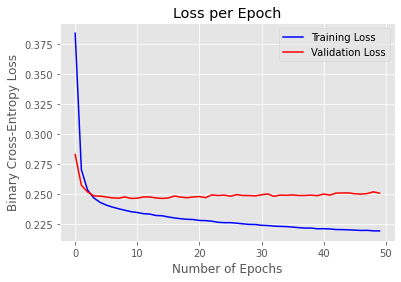

In [55]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

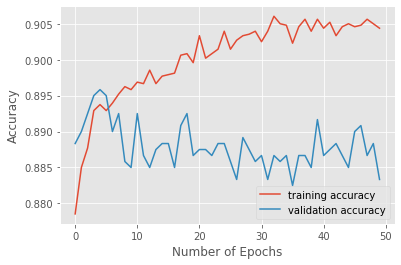

In [56]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Support Vector Machine

In [57]:
from sklearn import svm

svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(feat,svm_y, test_size = 0.6, shuffle=True)


clf = svm.SVC()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9154166666666667
Validation Accuracy:  0.8861111111111111


### Random Forest Classifier

In [58]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-58-fdfda7052fc4>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.8875


##  Generate the Test Graph and prepare Test Dataset

In [59]:
df_test.age = df_test.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_test.job = df_test.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_test.marital = df_test.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_test.education = df_test.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_test.default = df_test.default.apply(lambda x: 0 if x == 'no' else 1)

df_test.balance = df_test.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_test.housing = df_test.housing.apply(lambda x: 0 if x == 'no' else 1)

df_test.loan = df_test.loan.apply(lambda x: 0 if x == 'no' else 1)

df_test.contact = df_test.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

df_test.duration = df_test.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_test.pdays = df_test.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_test.poutcome = df_test.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_test.y = df_test.y.apply(lambda x: 0 if x == 'no' else 1)

df_test.drop(columns = ['day','month'],inplace=True)


In [60]:
genvars = df_test[['age','job','marital','education','balance','housing']] # add y for biased graph
genvars

,age,job,marital,education,balance,housing
0,3,1,1,1,2,1
1,1,1,1,1,3,1
2,2,1,1,1,3,1
3,3,1,1,1,2,1
4,3,1,1,3,3,1
...,...,...,...,...,...,...
5995,2,1,0,2,3,1
5996,1,1,1,0,2,1
5997,2,1,0,1,1,1
5998,2,1,1,1,2,1


In [61]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])

# outcome

y_alpha0 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha0,y_beta1],
                  [y_beta1,y_alpha0]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

In [62]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [63]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [64]:
A = A + A.T
np.sum(A) / 2

2262593.0

In [65]:
G_test = nx.from_numpy_matrix(A)

In [66]:
test_features = pd.Series(df_test.y)

## Add Test Data to dgl Graph

In [67]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = df_test.drop(columns=['y'])
#feat_test = pd.get_dummies(feat_test)
scale = StandardScaler()
feat_test = pd.DataFrame(scale.fit_transform(feat_test))

embedding_test = torch.tensor(feat_test.values,dtype=torch.float)

G_dgl_test.ndata['feat'] =  embedding_test
#G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.2)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [68]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define Inference Function

In [69]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([None])  # one layer at a time, taking all neighbors
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            # Allocate a buffer of output representations for every node
            # Note that the buffer is on CPU memory.
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0].to(torch.device('cpu'))

                x = input_features[input_nodes]

                # the following code is identical to the loop body in model.forward()
                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)
                    
                elif l == model.n_layers - 1:
                    x = F.log_softmax(x,dim=1)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

## Load trained GraphSage model parameters and get Test results

In [70]:
model.load_state_dict(torch.load('model.pt'))
all_predictions = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [71]:
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.835


In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.835
-------------------------------------------------------------
Confusion Matrix test set:
[[4679  600]
 [ 390  331]]
